**Run through visualizations and output datetime of collects to a csv**

In [ ]:
folder = Path('/Volumes/External/TJ_SAR/02_preprocessed/background_gooddays')

In [ ]:
from pathlib import Path
import csv
from datetime import datetime, timezone
from zoneinfo import ZoneInfo



# Timestamp formats
INPUT_FMT  = "%Y%m%dT%H%M%S"      # format in filename
OUTPUT_FMT = "%Y-%m-%d %H:%M:%S"  # human-readable output

# Timezones
UTC     = timezone.utc
PACIFIC = ZoneInfo("America/Los_Angeles")

# Prepare CSV output
csv_path = folder / "sentinel1_times.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    # Write header with original filename first
    writer.writerow(["original_filename", "start_utc", "start_local"])

    for p in sorted(folder.glob("*.png")):
        parts = p.stem.split("_")
        if len(parts) < 6:
            # skip unexpected filenames
            continue

        raw = parts[4]  # UTC start timestamp, e.g. "20250421T014857"
        try:
            dt_utc = datetime.strptime(raw, INPUT_FMT).replace(tzinfo=UTC)
        except ValueError:
            # skip malformed timestamps
            continue

        # Convert to Pacific time
        dt_local = dt_utc.astimezone(PACIFIC)

        # Write row
        writer.writerow([
            p.name,
            dt_utc.strftime(OUTPUT_FMT),
            dt_local.strftime(OUTPUT_FMT)
        ])

print(f"Wrote {csv_path.name} with {sum(1 for _ in folder.glob('*.png'))} entries.")


Wrote sentinel1_times.csv with 122 entries.


convert files from _overlay.png csv to a folder of their original raw dataset

In [4]:
import pandas as pd
from pathlib import Path
import shutil

# ─── CONFIG ──────────────────────────────────────────────────────────
csv_file    = Path('/_archive/test/sentinel1_times.csv')       # your CSV file
raw_folder  = Path('/01_data/02_2025_2020')  # root of all your raw .zip files
output_dir = Path('/01_data/03_2022_2025_gooddays')       # where to dump one-folder-per-scene
# ────────────────────────────────────────────────────────────────────

output_dir.mkdir(parents=True, exist_ok=True)

# Read just the original filenames
df = pd.read_csv(csv_file, usecols=['original_filename'])

for orig in df['original_filename'].dropna().unique():
    # strip suffix to get the scene base name
    scene_id = orig.rsplit('_pre_overlay.png', 1)[0]

    # find the zip(s) matching that base name
    matches = list(raw_folder.rglob(f'{scene_id}.zip'))
    if not matches:
        print(f'⚠️  No .zip found for scene "{scene_id}"')
        continue

    for zip_path in matches:
        dest = output_dir / zip_path.name
        # if you want to avoid overwriting, you could check .exists() here
        shutil.copy2(zip_path, dest)
        print(f'✔️  Copied "{zip_path.name}" to "{output_dir}"')


✔️  Copied "S1A_IW_GRDH_1SDV_20221203T015015_20221203T015044_046161_0586BC_72DC.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20221215T015014_20221215T015043_046336_058CB1_E040.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20221215T135316_20221215T135341_046343_058CF7_BB7D.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20230103T134452_20230103T134517_046620_059664_9029.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20230108T135315_20230108T135340_046693_0598D3_8F17.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20230917T015020_20230917T015049_050361_06103C_F092.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_2025_gooddays"
✔️  Copied "S1A_IW_GRDH_1SDV_20230924T134500_20230924T134525_050470_061400_0602.zip" to "/Volumes/External/TJ_SAR/01_data/03_2022_

Plot each shapefile over its corresponding tif

In [4]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# === USER PARAMETERS ===
shapefile_path        = "/Volumes/External/TJ_SAR/06_shapefiles/plumeExtentv3.shp"
point_shapefile_path  = "/Volumes/External/TJ_SAR/01_data/shapefiles/Outflow.shp"
tif_folder            = "/Volumes/External/TJ_SAR/02_preprocessed/background_gooddays"
output_folder         = "/Volumes/External/TJ_SAR/05_viz/Shapefiles"
debug                 = True   # set to False to silence CRS/bounds logs
# =======================

# ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# load polygon data
gdf = gpd.read_file(shapefile_path)
if debug:
    print("Polygon shapefile CRS:", gdf.crs)
    print("Unique sourceName values:", gdf["sourceName"].unique())

# load point data
pts_gdf = gpd.read_file(point_shapefile_path)
if debug:
    print("Point shapefile CRS:", pts_gdf.crs)
    print(" # points:", len(pts_gdf))

# loop per sourceName
for source, group in gdf.groupby("sourceName"):
    tif_path = os.path.join(tif_folder, f"{source}_pre.tif")
    if not os.path.exists(tif_path):
        print(f"⚠️  Missing TIFF for source {source!r}: {tif_path}")
        continue

    if debug:
        print(f"\n---\nSource: {source!r}, #polygons: {len(group)}")
        print(" Polygon bounds before reproj:", group.total_bounds)

    with rasterio.open(tif_path) as src:
        # read & mask
        arr = src.read(1).astype("float32")
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)

        # 2–95% stretch
        vmin, vmax = np.nanpercentile(arr, (2, 95))
        clipped     = np.clip(arr, vmin, vmax)
        normed      = (clipped - vmin) / (vmax - vmin)

        if debug:
            print(" Raster CRS:", src.crs)
            print(" Raster bounds:", src.bounds)

        # reproject vectors
        grp_proj = group.to_crs(src.crs)
        pts_proj = pts_gdf.to_crs(src.crs)
        if debug:
            print(" Polygon bounds after reproj:", grp_proj.total_bounds)
            print(" Point bounds after reproj:", pts_proj.total_bounds)

        # plot
        fig, ax = plt.subplots(figsize=(10, 10))

        # 1) raster
        show(normed,
             transform=src.transform,
             ax=ax,
             cmap="gray",
             title=source,
             adjust=None,
             zorder=0)

        # 2) polygons (lower zorder)
        grp_proj.boundary.plot(ax=ax,
                               edgecolor="red",
                               linewidth=1,
                               zorder=1)

        # 3) outflow points (higher zorder)
        pts_proj.plot(ax=ax,
                      marker='o',
                      markersize=30,
                      facecolor='yellow',
                      edgecolor='black',
                      linewidth=0.5,
                      zorder=2,
                      label='Outflow')

        ax.axis("off")

        # save
        out_path = os.path.join(output_folder, f"{source}.png")
        fig.savefig(out_path, bbox_inches="tight", pad_inches=0.1)
        plt.close(fig)

    print(f"✅  Saved plot: {out_path}")


Polygon shapefile CRS: EPSG:4326
Unique sourceName values: ['S1A_IW_GRDH_1SDV_20241216T015014_20241216T015043_057011_070161_E8F2'
 'S1A_IW_GRDH_1SDV_20240930T134456_20240930T134521_055895_06D520_6A0F'
 'S1A_IW_GRDH_1SDV_20240923T015016_20240923T015045_055786_06D0CD_4C0A'
 'S1A_IW_GRDH_1SDV_20240911T015016_20240911T015045_055611_06C9E7_3B08'
 'S1A_IW_GRDH_1SDV_20240830T015015_20240830T015045_055436_06C312_73FC'
 'S1A_IW_GRDH_1SDV_20240825T134455_20240825T134520_055370_06C0B3_2887'
 'S1A_IW_GRDH_1SDV_20241216T135316_20241216T135341_057018_0701B0_5892'
 'S1A_IW_GRDH_1SDV_20241122T135318_20241122T135343_056668_06F3D6_0258'
 'S1A_IW_GRDH_1SDV_20241005T135319_20241005T135344_055968_06D804_146E'
 'S1A_IW_GRDH_1SDV_20240923T135318_20240923T135343_055793_06D11E_354B'
 'S1A_IW_GRDH_1SDV_20240918T134456_20240918T134521_055720_06CE30_E1E3'
 'S1A_IW_GRDH_1SDV_20240725T015015_20240725T015044_054911_06B032_3EFF'
 'S1A_IW_GRDH_1SDV_20240619T015017_20240619T015046_054386_069DEF_1E63'
 'S1A_IW_GRDH_1SDV

Make Density Heatmap

In [15]:
#!/usr/bin/env python3
"""
plot_plume_heatmap_single.py

Reads a single plume-extent shapefile and plots a KDE heatmap,
masked so that no shading appears over land, using Cartopy for the land mask.
"""

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth

# ————————————————————————————————
# 1. LOAD YOUR PLUMES
# ————————————————————————————————

shapefile_path = "/Volumes/External/TJ_SAR/06_shapefiles/plumeExtentv3_Erase2.shp"
plumes = gpd.read_file(shapefile_path)

# If in geographic CRS, reproject to UTM for sensible distance-based KDE
if plumes.crs.is_geographic:
    plumes = plumes.to_crs(plumes.estimate_utm_crs())

# ————————————————————————————————
# 2. BUILD OCEAN MASK WITH CARTOPY
# ————————————————————————————————

# Cartopy ships Natural Earth admin_0_countries at 110m resolution
land_fp = natural_earth(
    resolution='110m',
    category='cultural',
    name='admin_0_countries'
)
land = gpd.read_file(land_fp).to_crs(plumes.crs)
land_union = land.unary_union

# Subtract land from the bounding box of the plumes
minx, miny, maxx, maxy = plumes.total_bounds
bbox = box(minx, miny, maxx, maxy)
ocean_area = bbox.difference(land_union)

# ————————————————————————————————
# 3. PLOT KDE HEATMAP
# ————————————————————————————————

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": gcrs.PlateCarree()}
)

# draw a light coastline for context
gplt.coastline(ax=ax, color="gray", linewidth=1)

# plot KDE, clipped to ocean_area so nothing shades land
gplt.kdeplot(
    plumes,
    ax=ax,
    projection=gcrs.PlateCarree(),
    cmap="Reds",
    shade=True,
    shade_lowest=False,
    clip=ocean_area,
    bw_adjust=0.5,    # tweak this for smoother/bumpier density
    alpha=0.7
)

# zoom to plume extent
ax.set_extent((minx, maxx, miny, maxy), crs=gcrs.PlateCarree())
ax.set_title("Plume-Extent KDE Heatmap (Ocean Only)", pad=20)

plt.tight_layout()
plt.show()



/Users/ereilly/RS/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>

*Add flow rate to csv from csv

In [20]:
import pandas as pd
from datetime import timedelta

def main():
    # --- Paths (adjust to your environment) ---
    MASTER_CSV = '/Volumes/External/TJ_SAR/analysis/master.csv'
    # Add your flow-rate site CSVs here
    FLOWRATE_SITES = {
        'TJNERR': '/Volumes/External/TJ_SAR/analysis/_data/Discharge.Instantaneous Flow.MGD@11013300-Instantaneous-M US Gal d-20250722142628.csv',
        'PB': '/Volumes/External/TJ_SAR/analysis/_data/Discharge.Telemetry-ADS-mgd@11-PUNTA-BANDERA-Instantaneous-M US Gal d.csv',
    }
    OUTPUT_CSV = '/Volumes/External/TJ_SAR/analysis/master_with_flowrate_avg.csv'

    # Conversion factor: million US gallons per day to cubic meters per second
    MGD_TO_M3S = 1e6 * 0.003785411784 / 86400

    # --- Load master and prepare UTC timestamps ---
    df_master = pd.read_csv(MASTER_CSV, parse_dates=['start_utc'], dayfirst=False)
    # Interpret start_utc as local Pacific time, convert to UTC-naive
    df_master['start_ts_utc'] = (
        df_master['start_utc']
        .dt.tz_localize('America/Los_Angeles', ambiguous='NaT', nonexistent='shift_forward')
        .dt.tz_convert('UTC')
        .dt.tz_localize(None)
    )

    # --- Helper to load flow data ---
    def load_flow(path):
        df = pd.read_csv(path, parse_dates=['Timestamp (UTC-08:00)'], dayfirst=False)
        df = df.rename(columns={
            'Timestamp (UTC-08:00)': 'timestamp',
            'Value (M US Gal/d)': 'flowrate_mgd'
        })
        # Convert mgd to m3/s
        df['flowrate_m3s'] = df['flowrate_mgd'] * MGD_TO_M3S
        # Interpret timestamp as local Pacific and convert
        df['timestamp_utc'] = (
            df['timestamp']
            .dt.tz_localize('America/Los_Angeles', ambiguous='NaT', nonexistent='shift_forward')
            .dt.tz_convert('UTC')
            .dt.tz_localize(None)
        )
        return df.sort_values('timestamp_utc')

    # --- Compute 24-hour average for each site ---
    for site, path in FLOWRATE_SITES.items():
        flow_df = load_flow(path)
        col = f'{site}_flowrate_24h_avg_m3s'
        df_master[col] = df_master['start_ts_utc'].apply(
            lambda t: (
                flow_df
                .loc[(flow_df['timestamp_utc'] > t - timedelta(hours=24)) & (flow_df['timestamp_utc'] <= t), 'flowrate_m3s']
                .mean()
            )
        )

    # --- Save results ---
    df_master.drop(columns=['start_ts_utc'], inplace=True)
    df_master.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved updated master with 24h m3/s averages for sites {list(FLOWRATE_SITES.keys())} to: {OUTPUT_CSV}")

if __name__ == '__main__':
    main()


/var/folders/t1/fsg48t9j38g7vrkbkp0603fr0000gq/T/ipykernel_61826/2774416999.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_master = pd.read_csv(MASTER_CSV, parse_dates=['start_utc'], dayfirst=False)
/var/folders/t1/fsg48t9j38g7vrkbkp0603fr0000gq/T/ipykernel_61826/2774416999.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, parse_dates=['Timestamp (UTC-08:00)'], dayfirst=False)


Saved updated master with 24h m3/s averages for sites ['TJNERR', 'PB'] to: /Volumes/External/TJ_SAR/analysis/master_with_flowrate_avg.csv


find the nearest wind field point to each outfall location and add to csv


In [26]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ---------------- Configuration ----------------
csv_path = "/Volumes/External/TJ_SAR/analysis/master_with_flowrate_avg.csv"
wind_shp_dir = "/Volumes/External/TJ_SAR/analysis/windFields"
outflow_shp = "/Volumes/External/TJ_SAR/01_data/shapefiles/Outflow.shp"
plot_output_dir = "/Volumes/External/TJ_SAR/analysis/nearest_plots"
output_csv = "/Volumes/External/TJ_SAR/analysis/master_with_flowrate_with_wind.csv"

# Create directory for plots
os.makedirs(plot_output_dir, exist_ok=True)

# Load master table
df = pd.read_csv(csv_path)
df['original_filename'] = df['original_filename'].fillna("").astype(str)

# Load Outflow shapefile once
gdf_outflow = gpd.read_file(outflow_shp)
n_points = len(gdf_outflow)
if n_points == 0:
    raise ValueError("Outflow shapefile contains no points.")

# Choose a projected CRS for accurate distances (UTM based on outflow centroid)
utm_crs = gdf_outflow.estimate_utm_crs()
# Reproject outflow points
gdf_outflow_proj = gdf_outflow.to_crs(utm_crs)

# Prepare output columns container
data = {}
for i in range(n_points):
    data[f"heading_point_{i+1}"] = []
    data[f"speed_point_{i+1}"] = []

# Helper to get wind shapefile path and base name
def get_wind_shp_path(fname):
    if fname.endswith('_pre_overlay.png'):
        base = fname[:-len('_pre_overlay.png')]
    else:
        base = os.path.splitext(fname)[0]
    return os.path.join(wind_shp_dir, f"{base}_Cal_Point.shp"), base

# Process each row/image
for _, row in df.iterrows():
    fname = row['original_filename']
    shp_path, base = get_wind_shp_path(fname)

    # If missing or shapefile absent: fill NaNs
    if not fname or not os.path.exists(shp_path):
        for i in range(n_points):
            data[f"heading_point_{i+1}"].append(pd.NA)
            data[f"speed_point_{i+1}"].append(pd.NA)
        continue

    # Load wind field and reproject to UTM
    gdf_wind = gpd.read_file(shp_path)
    gdf_wind_proj = gdf_wind.to_crs(utm_crs)

    # Compute nearest per outflow point by distance in projected CRS
    nearest_idx_list = []
    for pt in gdf_outflow_proj.geometry:
        # compute distances and find minimum
        dists = gdf_wind_proj.geometry.distance(pt)
        idx_min = dists.idxmin()
        nearest_idx_list.append(idx_min)

    # Extract and store heading/speed
    for i, wind_idx in enumerate(nearest_idx_list):
        heading_val = gdf_wind.loc[wind_idx, 'heading']
        speed_val   = gdf_wind.loc[wind_idx, 'speed']
        data[f"heading_point_{i+1}"].append(heading_val)
        data[f"speed_point_{i+1}"].append(speed_val)

    # Plot for QC
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # show all wind points (lightgrey)
    gdf_wind_proj.plot(ax=ax, color='lightgrey', markersize=10)
    # show outflow
    gdf_outflow_proj.plot(ax=ax, color='blue', marker='o', markersize=40, label='Outflow')
    # show nearest wind
    nearest_wind_pts = gdf_wind_proj.loc[nearest_idx_list]
    nearest_wind_pts.plot(ax=ax, color='red', marker='x', markersize=80, label='Nearest')
    # connect
    for out_pt, wind_pt in zip(gdf_outflow_proj.geometry, nearest_wind_pts.geometry):
        ax.plot([out_pt.x, wind_pt.x], [out_pt.y, wind_pt.y], linestyle='--')
    ax.set_title(f"Nearest Wind for {base}")
    ax.legend()
    fig.savefig(os.path.join(plot_output_dir, f"{base}_nearest.png"), bbox_inches='tight')
    plt.close(fig)

# Attach to DataFrame and write output
for col, vals in data.items():
    df[col] = vals
df.to_csv(output_csv, index=False)
print(f"Done: CSV at {output_csv}, plots at {plot_output_dir}")


Done: CSV at /Volumes/External/TJ_SAR/analysis/master_with_flowrate_with_wind.csv, plots at /Volumes/External/TJ_SAR/analysis/nearest_plots


add area SQKM from shapefile to the csv

In [27]:
import pandas as pd
import geopandas as gpd

# Paths
csv_path = "/Volumes/External/TJ_SAR/analysis/master_with_flowrate_with_wind.csv"
shp_path = "/Volumes/External/TJ_SAR/01_data/shapefiles/plumeExtentv4.shp"

# Load
df = pd.read_csv(csv_path)
gdf = gpd.read_file(shp_path)

# Create a bare filename for merging
df['base_name'] = df['original_filename'].str.replace(r'_pre_overlay\.png$', '', regex=True)

# Keep only the key fields in the shapefile
gdf_small = gdf[['sourceName', 'area_SQKM']]

# Merge on base_name ↔ sourceName
merged = df.merge(
    gdf_small,
    left_on='base_name',
    right_on='sourceName',
    how='left'
)

# Drop helper columns
merged = merged.drop(columns=['base_name', 'sourceName'])

# Write back
merged.to_csv(csv_path, index=False)

print("Done — ‘area_SQKM’ added, matched by stripping the suffix.")


Done — ‘area_SQKM’ added, matched by stripping the suffix.


In [28]:
import pandas as pd
import geopandas as gpd

# — your file paths —
csv_path = "/Volumes/External/TJ_SAR/analysis/master_with_flowrate_with_wind.csv"
shp_path = "/Volumes/External/TJ_SAR/01_data/shapefiles/plumeExtentv4.shp"

# 1. Load CSV & shapefile
df = pd.read_csv(csv_path)
gdf = gpd.read_file(shp_path)

# 2. Strip suffix for matching
df['base_name'] = df['original_filename'].str.replace(
    r'_pre_overlay\.png$', '', regex=True
)

# 3. Pivot shapefile so each sourceName has two columns: area_SQKM_SAB and area_SQKM_TJ
#    - sum() in case you have multiple polygons per group
pivot = (
    gdf[['sourceName', 'outflow', 'area_SQKM']]
    .pivot_table(
        index='sourceName',
        columns='outflow',
        values='area_SQKM',
        aggfunc='sum'
    )
    .rename(columns={
        'SAB': 'area_SQKM_SAB',
        'TJ':  'area_SQKM_TJ'
    })
    .reset_index()
)

# 4. Merge pivoted areas into your CSV
merged = df.merge(
    pivot,
    left_on='base_name',
    right_on='sourceName',
    how='left'
)

# 5. Clean up helper columns (optional)
merged = merged.drop(columns=['base_name', 'sourceName'])

# 6. Save back to CSV (overwrite—or change path if you’d like to keep original)
merged.to_csv(csv_path, index=False)

print("Done — CSV now has both ‘area_SQKM_SAB’ and ‘area_SQKM_TJ’ columns.")


Done — CSV now has both ‘area_SQKM_SAB’ and ‘area_SQKM_TJ’ columns.


In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np

# — your file paths —
csv_path = "/Volumes/External/TJ_SAR/analysis/master_with_flowrate_with_wind.csv"
shp_path = "/Volumes/External/TJ_SAR/01_data/shapefiles/plumeExtentv4.shp"

# 1. Load CSV & shapefile
df = pd.read_csv(csv_path)
gdf = gpd.read_file(shp_path)

# 2. Strip suffix and normalize
df['base_name'] = (
    df['original_filename']
      .str.replace(r'_pre_overlay\.png$', '', regex=True)
      .str.lower()
      .str.strip()
)

# 3. Pivot shapefile to get SAB/TJ areas
g = gdf[['sourceName', 'outflow', 'area_SQKM']].copy()
g['source_lc'] = g['sourceName'].str.lower().str.strip()
pivot = (
    g.pivot_table(
         index='source_lc',
         columns='outflow',
         values='area_SQKM',
         aggfunc='sum'
    )
     .rename(columns={'SAB': 'area_SQKM_SAB', 'TJ': 'area_SQKM_TJ'})
     .reset_index()
)

# 4. Merge back onto your CSV
merged = df.merge(
    pivot,
    left_on='base_name',
    right_on='source_lc',
    how='left'
)

# 5. Ensure both area columns always exist (to avoid KeyError)
for col in ['area_SQKM_SAB', 'area_SQKM_TJ']:
    if col not in merged.columns:
        merged[col] = np.nan

# 6. DEBUG: show exactly what columns you have now
print("🛠️ Columns in merged:")
print(merged.columns.tolist())

# Also peek at the first few values of your key columns
print("\n🛠️ Sample of area columns:")
print( merged[['original_filename','base_name','area_SQKM_SAB','area_SQKM_TJ']]
       .head(10)
       .to_string(index=False) )

# 7. Diagnostics: which base_names didn’t match anything?
missing = set(df['base_name']) - set(pivot['source_lc'])
print(f"\n📌 {len(missing)} filenames not in shapefile. Examples: {sorted(missing)[:10]}")

unused = set(pivot['source_lc']) - set(df['base_name'])
print(f"📌 {len(unused)} shapefile entries not in CSV. Examples: {sorted(unused)[:10]}")

# 8. Save back out (dropping helper cols)
out = merged.drop(columns=['base_name','source_lc'])
out.to_csv(csv_path, index=False)
print("\n✅ Done—CSV updated (any missing areas are NaN).")



🛠️ Columns in merged:
['original_filename', 'start_utc', 'start_local', 'TJ', 'PB', 'TJ_area_sqkm', 'PB_area_sqkm', 'Wind', 'River Discharge', 'Quality?', 'Flow Direction', 'Unnamed: 11', 'discharge_24hr_MG', 'totalflow_24hr_MG', 'wind_speed', 'wind_direction', 'TJNERR_flowrate_24h_avg_m3s', 'PB_flowrate_24h_avg_m3s', 'heading_point_1', 'speed_point_1', 'heading_point_2', 'speed_point_2', 'area_SQKM', 'area_SQKM_SAB_x', 'area_SQKM_TJ_x', 'base_name', 'source_lc', 'area_SQKM_SAB_y', 'area_SQKM_TJ_y', 'area_SQKM_SAB', 'area_SQKM_TJ']

🛠️ Sample of area columns:
                                                                  original_filename                                                           base_name  area_SQKM_SAB  area_SQKM_TJ
S1A_IW_GRDH_1SDV_20221203T015015_20221203T015044_046161_0586BC_72DC_pre_overlay.png s1a_iw_grdh_1sdv_20221203t015015_20221203t015044_046161_0586bc_72dc            NaN           NaN
S1A_IW_GRDH_1SDV_20221210T134454_20221210T134519_046270_058A79_9DD5_pre_

In [3]:
#!/usr/bin/env python3
"""
Script to generate a regularly spaced grid of points (100 m) within each polygon of a shapefile,
carrying over the 'sourceName' attribute for each point.
All processing in UTM zone 11N (EPSG:32611).
"""

import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Step 1: Read the input shapefile
tinput = "/Volumes/External/TJ_SAR/01_data/shapefiles/plumeExtentv4.shp"
polygons = gpd.read_file(tinput)

# Step 2: Reproject to UTM zone 11N (EPSG:32611)
polygons = polygons.to_crs(epsg=32611)

# Step 3: Define a function to create a grid of points within a single polygon
def generate_grid_points(polygon, spacing):
    """
    Generate points on a regular grid with given spacing inside a polygon.

    :param polygon: shapely Polygon in the correct CRS
    :param spacing: grid spacing in CRS units (meters)
    :return: list of shapely Point objects
    """
    minx, miny, maxx, maxy = polygon.bounds
    x_coords = np.arange(minx, maxx + spacing, spacing)
    y_coords = np.arange(miny, maxy + spacing, spacing)
    points = []
    for x in x_coords:
        for y in y_coords:
            p = Point(x, y)
            if polygon.contains(p):
                points.append(p)
    return points

# Step 4: Loop through each feature and generate points, retaining sourceName
all_points = []
feature_ids = []
source_names = []
spacing = 100  # meters

for idx, feature in polygons.iterrows():
    src = feature.get('sourceName')  # retrieve sourceName attribute
    pts = generate_grid_points(feature.geometry, spacing)
    all_points.extend(pts)
    feature_ids.extend([idx] * len(pts))
    source_names.extend([src] * len(pts))

# Step 5: Build a GeoDataFrame of the points
points_gdf = gpd.GeoDataFrame(
    {
        "feature_id": feature_ids,
        "sourceName": source_names,
        "geometry": all_points
    },
    crs=polygons.crs
)

# Step 6: Write the output to a new shapefile
output = "/Volumes/External/TJ_SAR/01_data/shapefiles/output_points.shp"
points_gdf.to_file(output)

print(f"Generated {len(points_gdf)} points and saved to '{output}'")


Generated 38593 points and saved to '/Volumes/External/TJ_SAR/01_data/shapefiles/output_points.shp'


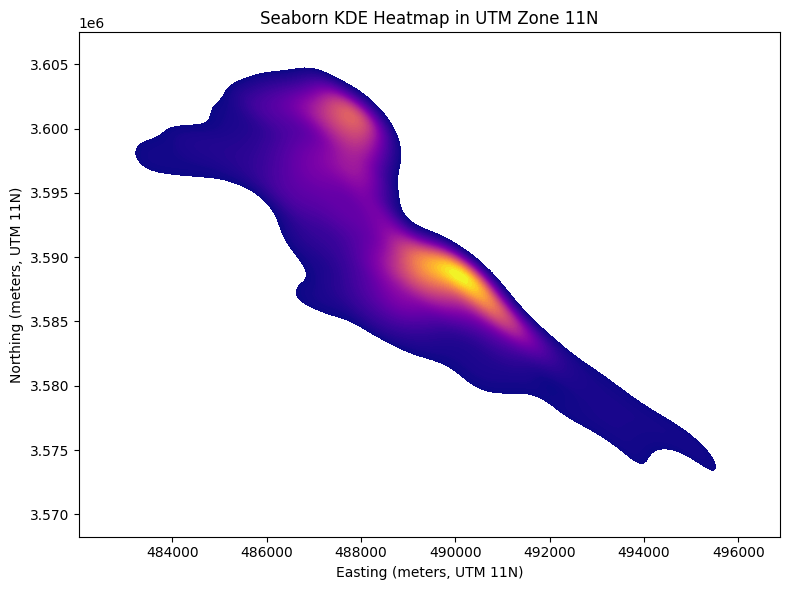

NameError: name 'from_bounds' is not defined

In [8]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read your Shapefile and project to UTM Zone 11N
gdf = (
    gpd.read_file("/Volumes/External/TJ_SAR/01_data/shapefiles/output_points.shp")
       .to_crs(epsg=26911)   # WGS84 / UTM zone 11N
)

# 2. Extract Easting (X) and Northing (Y)
df = gdf.assign(
    X = gdf.geometry.x,
    Y = gdf.geometry.y
)[["X", "Y"]]

# 3. Plot the KDE heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x="X", y="Y", data=df,
    fill=True,
    thresh=0.05,
    levels=100,
    cmap="plasma"
)
plt.title("Seaborn KDE Heatmap in UTM Zone 11N")
plt.xlabel("Easting (meters, UTM 11N)")
plt.ylabel("Northing (meters, UTM 11N)")
plt.tight_layout()
plt.show()

transform = from_bounds(
    west=xmin, south=ymin,
    east=xmax, north=ymax,
    width=zi.shape[1],  # number of columns
    height=zi.shape[0], # number of rows
)

# 2. Open a new GeoTIFF for writing
with rasterio.open(
    "/Volumes/External/TJ_SAR/01_data/shapefiles/density.tif",            # output filename
    mode="w",
    driver="GTiff",                         # GeoTIFF format
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,                                # one band
    dtype=zi.dtype,                         # match your numpy array type
    crs="EPSG:32611",                       # declare UTM Zone 11N
    transform=transform,
) as dst:
    dst.write(zi, 1)                        # write your density array to band 1

In [2]:
#!/usr/bin/env python3
"""
Script to generate a regularly spaced grid of points (100 m) within each polygon of a shapefile.
All processing in UTM zone 11N (EPSG:32611).
"""

import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Step 1: Read the input shapefile
tinput = "/Volumes/External/TJ_SAR/01_data/shapefiles/plumeExtentv4.shp"
polygons = gpd.read_file(tinput)

# Step 2: Reproject to UTM zone 11N (EPSG:32611)
polygons = polygons.to_crs(epsg=32611)

# Step 3: Define a function to create a grid of points within a single polygon
def generate_grid_points(polygon, spacing):
    """
    Generate points on a regular grid with given spacing inside a polygon.

    :param polygon: shapely Polygon in the correct CRS
    :param spacing: grid spacing in CRS units (meters)
    :return: list of shapely Point objects
    """
    minx, miny, maxx, maxy = polygon.bounds
    x_coords = np.arange(minx, maxx + spacing, spacing)
    y_coords = np.arange(miny, maxy + spacing, spacing)
    points = []
    for x in x_coords:
        for y in y_coords:
            p = Point(x, y)
            if polygon.contains(p):
                points.append(p)
    return points

# Step 4: Loop through each feature and generate points
all_points = []
feature_ids = []
for idx, feature in polygons.iterrows():
    pts = generate_grid_points(feature.geometry, 100)
    all_points.extend(pts)
    feature_ids.extend([idx] * len(pts))

# Step 5: Build a GeoDataFrame of the points
points_gdf = gpd.GeoDataFrame(
    {"feature_id": feature_ids, "geometry": all_points},
    crs=polygons.crs
)

# Step 6: Write the output to a new shapefile
output = "/Volumes/External/TJ_SAR/01_data/shapefiles/output_points.shp"
points_gdf.to_file(output)

print(f"Generated {len(points_gdf)} points and saved to '{output}'")


Generated 38593 points and saved to '/Volumes/External/TJ_SAR/01_data/shapefiles/output_points.shp'


**calculate lag effect and best window for precipitation dataset**

In [17]:
import numpy as np
import pandas as pd

prism_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/Master_with_PRISM_2daymean.xlsx")



In [18]:
print(prism_df.columns)

Index(['original_filename', 'start_utc', 'start_local', 'TJ', 'PB',
       'TJ_area_sqkm', 'PB_area_sqkm', 'area_total', 'Flow Direction',
       'wind_speed', 'wind_direction', 'TJNERR_flowrate_24h_avg_m3s',
       'PB_flowrate_24h_avg_m3s', 'heading_point_1', 'speed_point_1',
       'heading_point_2', 'speed_point_2', 'ppt_pb_prev1', 'ppt_pb_prev2',
       'ppt_pb_mean2', 'ppt_tj_prev1', 'ppt_tj_prev2', 'ppt_tj_mean2'],
      dtype='object')


In [ ]:

# assume df has columns 'date', 'precip_mm', 'plume_size'
df = pd.read_csv("your_data.csv", parse_dates=["start_utc"]).set_index("start_utc")

# ensure equal spacing and no missing days
df = df.asfreq("D").interpolate()

# subtract mean
x = df["precip_mm"] - df["precip_mm"].mean()
y = df["plume_size"] - df["plume_size"].mean()

# compute cross-correlation for lags -max_lag…+max_lag
max_lag = 14  # days
lags = np.arange(-max_lag, max_lag+1)
ccf = [np.corrcoef(x.shift(-lag).iloc[max_lag:-max_lag],
                   y.iloc[max_lag:-max_lag])[0,1]
       for lag in lags]

# find lag of maximum absolute correlation
best_idx = np.nanargmax(np.abs(ccf))
best_lag = lags[best_idx]
best_corr = ccf[best_idx]
print(f"Highest |r| at lag {best_lag} days (r = {best_corr:.2f})")


**add precipitation data to spreadsheet**

In [62]:
import pandas as pd

# 1. File paths
master_path = "/Volumes/External/TJ_SAR/analysis/Master.xlsx"
prism_path  = "/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx"

# 2. Load data
master_df = pd.read_excel(master_path)
prism_df  = pd.read_excel(prism_path)

# 3. Convert UTC timestamps to Pacific-local dates
master_df['start_utc']   = pd.to_datetime(master_df['start_utc'], utc=True)
master_df['date_local']  = (master_df['start_utc']
                             .dt.tz_convert('America/Los_Angeles')
                             .dt.normalize()
                             .dt.date)

# 4. Prepare PRISM: parse date, reshape to long form
prism_df['date'] = pd.to_datetime(prism_df['Date']).dt.date
prism_long = prism_df.melt(
    id_vars='date',
    value_vars=['ppt_tj', 'ppt_pb'],
    var_name='ppt_var',
    value_name='ppt_in'
)
prism_long['Site'] = prism_long['ppt_var'].map({'ppt_tj':'TJ','ppt_pb':'PB'})
prism_long = prism_long[['date','Site','ppt_in']]

# 5. Compute dates: same day, 1, 2, 3 days before
master_df['d0'] = master_df['date_local']
master_df['d1'] = master_df['date_local'] - pd.Timedelta(days=1)
master_df['d2'] = master_df['date_local'] - pd.Timedelta(days=2)
master_df['d3'] = master_df['date_local'] - pd.Timedelta(days=3)

# 6. Merge precipitation for d0–d3
df = master_df.copy()

for i in range(4):
    df = df.merge(
        prism_long,
        left_on=['d{}'.format(i), 'Site'],
        right_on=['date','Site'],
        how='left'
    ).rename(columns={'ppt_in': f'ppt{i}'}).drop(columns=['date'])

# 7. Classify wet/dry if any of ppt0–ppt3 exceed threshold
threshold = 0.00393701  # inches
df['weather_class'] = df[[f'ppt{i}' for i in range(4)]].gt(threshold).any(axis=1).map({True: 'wet', False: 'dry'})

# 8. Save to CSV
output_path = "/Volumes/External/TJ_SAR/analysis/precip_condition.csv"
df.to_csv(output_path, index=False)

print(f"Saved classification with ppt0–ppt3 and weather_class to:\n{output_path}")



Saved classification with ppt0–ppt3 and weather_class to:
/Volumes/External/TJ_SAR/analysis/precip_condition.csv


In [93]:
import pandas as pd

# 1. File paths (adjust if necessary)
master_path = "/Volumes/External/TJ_SAR/analysis/Master.xlsx"
prism_path  = "/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx"

# 2. Load data
master_df = pd.read_excel(master_path)
prism_df  = pd.read_excel(prism_path)

# 3. Convert UTC to Pacific-local dates
master_df['start_utc']  = pd.to_datetime(master_df['start_utc'], utc=True)
master_df['date_local'] = (
    master_df['start_utc']
      .dt.tz_convert('America/Los_Angeles')
      .dt.normalize()
      .dt.date
)

# 4. Prepare daily precip pivot per site
prism_df['date'] = pd.to_datetime(prism_df['Date']).dt.date
daily_precip = prism_df.set_index('date')[['ppt_tj','ppt_pb']].rename(columns={'ppt_tj':'TJ','ppt_pb':'PB'})

# 5. Define threshold and boolean rain/dry
threshold = 0.00393701  # inches
is_rain = daily_precip > threshold
is_dry  = ~is_rain

# 6. Compute rolling dry-day streak ending before each date
streak = pd.DataFrame(index=is_dry.index, columns=is_dry.columns, dtype=int)
for site in is_dry.columns:
    count = 0
    vals = []
    for dry in is_dry[site]:
        count = count + 1 if dry else 0
        vals.append(count)
    streak[site] = vals
streak_prior = streak.shift(1).fillna(0).astype(int)

# 7. Determine event end and antecedent dry days
def classify_event(row):
    t = row['date_local']
    site = row['Site']
    # Look back up to 3 days
    window = [t - pd.Timedelta(days=d) for d in range(0, 4)]
    # Filter only those in index
    rain_days = [d for d in window if d in is_rain.index and is_rain.at[d, site]]
    if not rain_days:
        return pd.Series({'event_end': None, 'dry_before': None, 'weather_class': 'dry'})
    # End of event is the most recent rain day within window
    event_end = max(rain_days)
    dry_before = streak_prior.at[event_end, site]
    return pd.Series({'event_end': event_end, 'dry_before': dry_before, 'weather_class': 'wet'})

# Apply to each master row
result = master_df[['date_local','Site']].apply(classify_event, axis=1)
master_df = pd.concat([master_df, result], axis=1)

# 8. Save output
output_path = "/Volumes/External/TJ_SAR/analysis/precip_event_dry_streak.csv"
master_df.to_csv(output_path, index=False)

# 9. Preview
print(master_df[['date_local','Site','event_end','dry_before','weather_class']].head(10))


   date_local Site   event_end  dry_before weather_class weather_class
0  2025-05-08   TJ  2025-05-05         0.0           wet           wet
1  2025-05-08   PB  2025-05-05         0.0           wet           wet
2  2025-04-20   PB        None         NaN           dry           dry
3  2025-03-09   TJ  2025-03-09         1.0           wet           wet
4  2025-03-09   PB  2025-03-09         1.0           wet           wet
5  2025-02-25   TJ        None         NaN           dry           dry
6  2025-02-25   PB        None         NaN           dry           dry
7  2025-02-02   PB        None         NaN           dry           dry
8  2025-02-01   PB        None         NaN           dry           dry
9  2024-12-16   PB  2024-12-13        18.0           wet           wet


**visualizations not sure if they are new or old**

In [65]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt


# 1. File paths
master_path = "/Volumes/External/TJ_SAR/analysis/Master.xlsx"
master_df = pd.read_excel(master_path)
print(master_df.columns)

Index(['original_filename', 'start_utc', 'start_local', 'Site', 'area_sqkm',
       'Flow Direction', 'wind_speed', 'wind_direction',
       'TJNERR_flowrate_24h_avg_m3s', 'PB_flowrate_24h_avg_m3s',
       'heading_point_1', 'speed_point_1', 'heading_point_2', 'speed_point_2',
       'ppt0', 'ppt1', 'ppt2', 'ppt3', 'weather_class'],
      dtype='object')


Index(['original_filename', 'start_utc', 'start_local', 'Site', 'area_sqkm',
       'Flow Direction', 'wind_speed', 'wind_direction',
       'TJNERR_flowrate_24h_avg_m3s', 'PB_flowrate_24h_avg_m3s',
       'heading_point_1', 'speed_point_1', 'heading_point_2', 'speed_point_2',
       'ppt0', 'ppt1', 'ppt2', 'ppt3', 'avg_ppt', 'weather_class'],
      dtype='object')


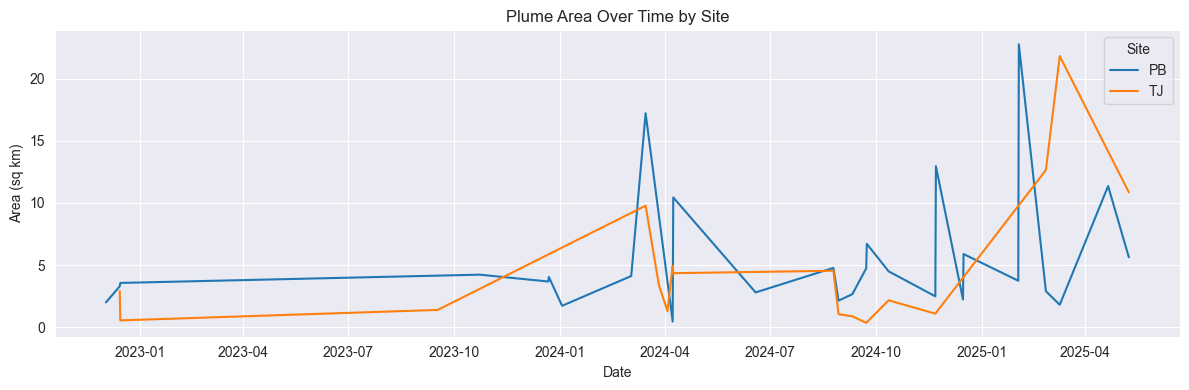

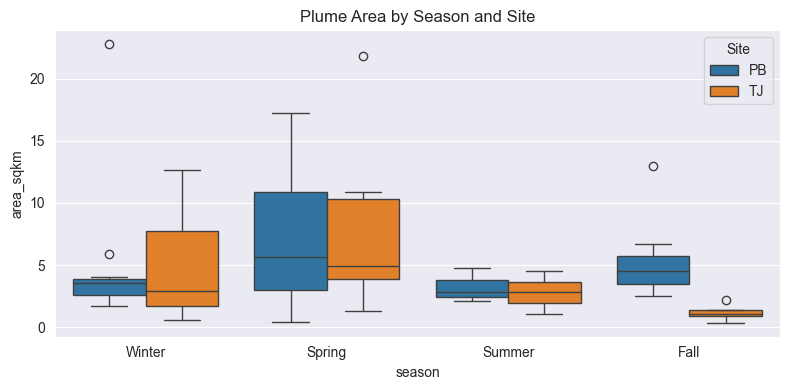

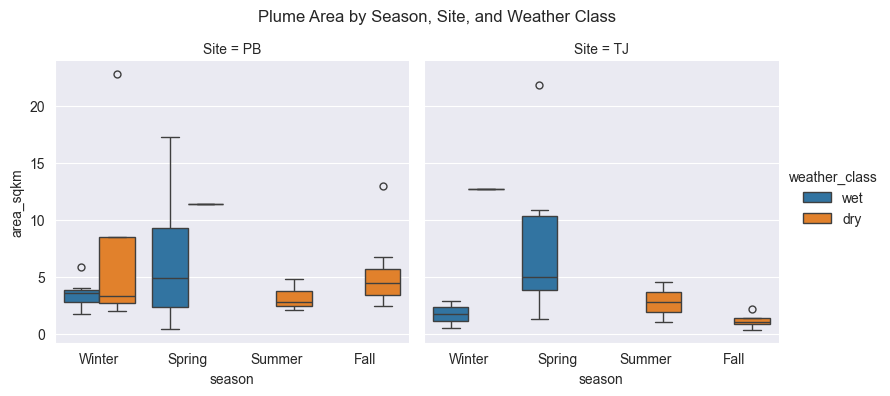

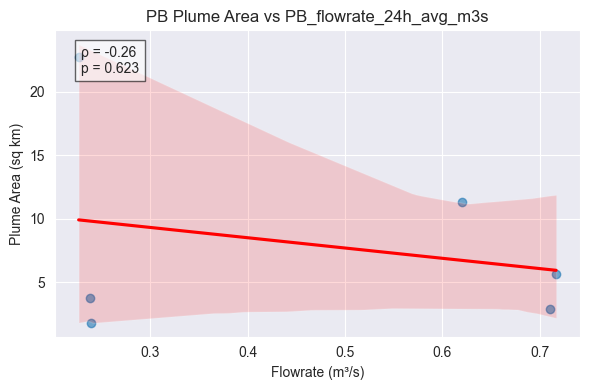

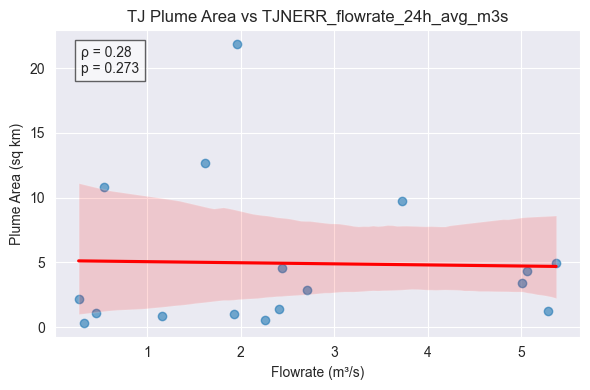

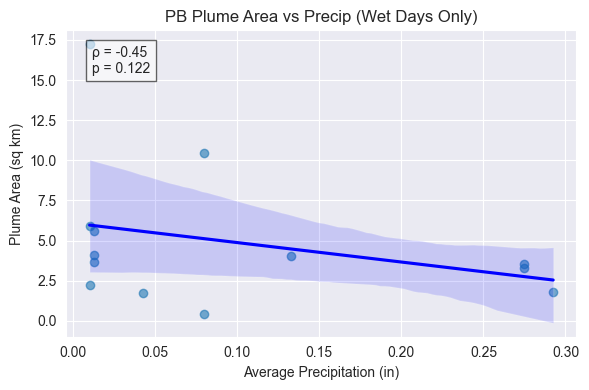

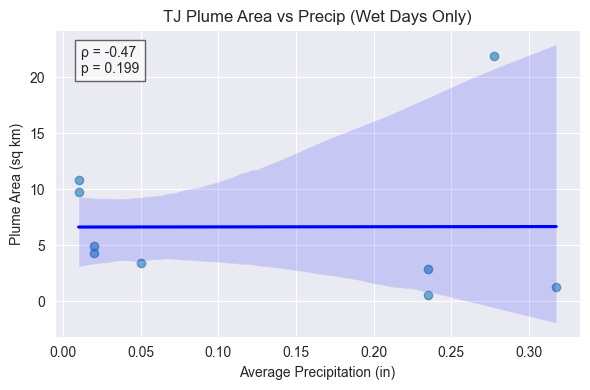

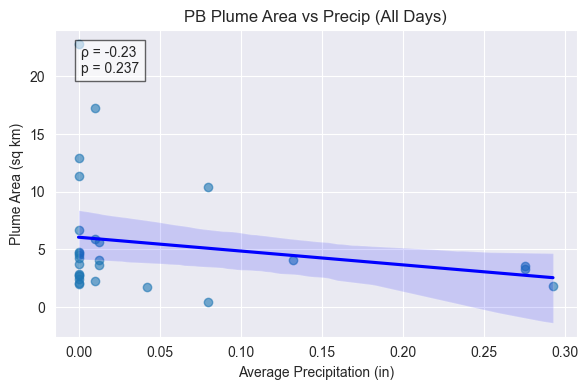

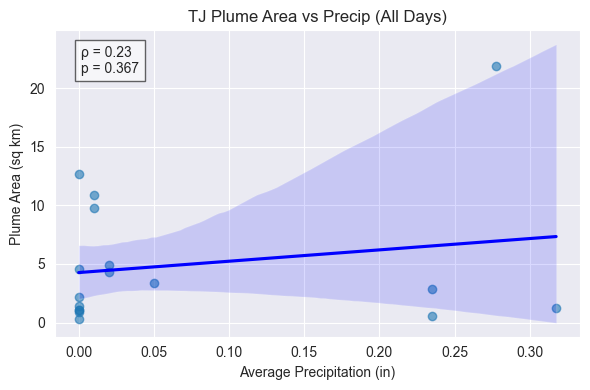

In [8]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import pytz

# 1. Load the master dataset
master_path = "/Volumes/External/TJ_SAR/analysis/Master.xlsx"
df = pd.read_excel(master_path)
print(df.columns)

# 2. Convert UTC to Pacific Time
df['start_utc'] = pd.to_datetime(df['start_utc'], errors='coerce', utc=True)
pacific = pytz.timezone('America/Los_Angeles')
df['start_local'] = df['start_utc'].dt.tz_convert(pacific)

# 3. Add temporal and seasonal info
df['month'] = df['start_local'].dt.month
df['year'] = df['start_local'].dt.year

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# 4. Time series plot of plume area (raw)
plt.figure(figsize=(12, 4))
sns.lineplot(data=df, x='start_local', y='area_sqkm', hue='Site')
plt.title('Plume Area Over Time by Site')
plt.xlabel('Date')
plt.ylabel('Area (sq km)')
plt.tight_layout()
plt.show()


# 5. Boxplot: plume area by season and site
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='season', y='area_sqkm', hue='Site', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Plume Area by Season and Site')
plt.tight_layout()
plt.show()

# 6. Boxplot: plume area by season and weather class per site
g = sns.catplot(
    data=df, kind='box',
    x='season', y='area_sqkm', hue='weather_class',
    col='Site', order=['Winter', 'Spring', 'Summer', 'Fall'],
    height=4, aspect=1
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Plume Area by Season, Site, and Weather Class')
plt.show()

# 7. Scatterplots: area vs flowrate per site
for site in df['Site'].unique():
    df_site = df[df['Site'] == site]
    flow_col = 'TJNERR_flowrate_24h_avg_m3s' if site == 'TJ' else 'PB_flowrate_24h_avg_m3s'

    subset = df_site[[flow_col, 'area_sqkm']].dropna()
    if len(subset) < 3:
        continue

    rho, pval = spearmanr(subset[flow_col], subset['area_sqkm'])

    plt.figure(figsize=(6, 4))
    sns.regplot(data=subset, x=flow_col, y='area_sqkm',
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    plt.title(f'{site} Plume Area vs {flow_col}')
    plt.xlabel('Flowrate (m³/s)')
    plt.ylabel('Plume Area (sq km)')
    plt.text(0.05, 0.95, f"ρ = {rho:.2f}\np = {pval:.3f}",
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
    plt.tight_layout()
    plt.show()

# 8. Scatterplots: area vs avg_ppt (wet days only) per site
for site in df['Site'].unique():
    df_site = df[(df['Site'] == site) & (df['weather_class'] == 'wet')]
    subset = df_site[['avg_ppt', 'area_sqkm']].dropna()
    if len(subset) < 3:
        continue

    rho, pval = spearmanr(subset['avg_ppt'], subset['area_sqkm'])

    plt.figure(figsize=(6, 4))
    sns.regplot(data=subset, x='avg_ppt', y='area_sqkm',
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'blue'})
    plt.title(f'{site} Plume Area vs Precip (Wet Days Only)')
    plt.xlabel('Average Precipitation (in)')
    plt.ylabel('Plume Area (sq km)')
    plt.text(0.05, 0.95, f"ρ = {rho:.2f}\np = {pval:.3f}",
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
    plt.tight_layout()
    plt.show()


    # 9. Scatterplots: area vs avg_ppt (ALL days) per site
for site in df['Site'].unique():
    df_site = df[df['Site'] == site]
    subset = df_site[['avg_ppt', 'area_sqkm']].dropna()
    if len(subset) < 3:
        continue

    rho, pval = spearmanr(subset['avg_ppt'], subset['area_sqkm'])

    plt.figure(figsize=(6, 4))
    sns.regplot(data=subset, x='avg_ppt', y='area_sqkm',
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'blue'})
    plt.title(f'{site} Plume Area vs Precip (All Days)')
    plt.xlabel('Average Precipitation (in)')
    plt.ylabel('Plume Area (sq km)')
    plt.text(0.05, 0.95, f"ρ = {rho:.2f}\np = {pval:.3f}",
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
    plt.tight_layout()
    plt.show()



In [75]:
##correlation stuff

for site in df['Site'].unique():
    # All days
    df_all = df[df['Site'] == site][['avg_ppt', 'area_sqkm']].dropna()
    rho_all, _ = spearmanr(df_all['avg_ppt'], df_all['area_sqkm'])

    # Wet only
    df_wet = df[(df['Site'] == site) & (df['weather_class'] == 'wet')][['avg_ppt', 'area_sqkm']].dropna()
    rho_wet, _ = spearmanr(df_wet['avg_ppt'], df_wet['area_sqkm'])

    print(f"{site} – Spearman ρ:")
    print(f"  All days: {rho_all:.2f}")
    print(f"  Wet only: {rho_wet:.2f}")

for site in df['Site'].unique():
    df_site = df[(df['Site'] == site) & (df['weather_class'] == 'wet')]

    ppt_corr = spearmanr(df_site['avg_ppt'], df_site['area_sqkm'], nan_policy='omit')[0]

    flow_col = 'TJNERR_flowrate_24h_avg_m3s' if site == 'TJ' else 'PB_flowrate_24h_avg_m3s'
    flow_corr = spearmanr(df_site[flow_col], df_site['area_sqkm'], nan_policy='omit')[0]

    print(f"{site} (Wet Days Only):")
    print(f"  ρ(Precip vs Area): {ppt_corr:.2f}")
    print(f"  ρ(Flowrate vs Area): {flow_corr:.2f}")

TJ – Spearman ρ:
  All days: 0.23
  Wet only: -0.47
PB – Spearman ρ:
  All days: -0.23
  Wet only: -0.45
TJ (Wet Days Only):
  ρ(Precip vs Area): -0.47
  ρ(Flowrate vs Area): -0.33
PB (Wet Days Only):
  ρ(Precip vs Area): -0.45
  ρ(Flowrate vs Area): 1.00


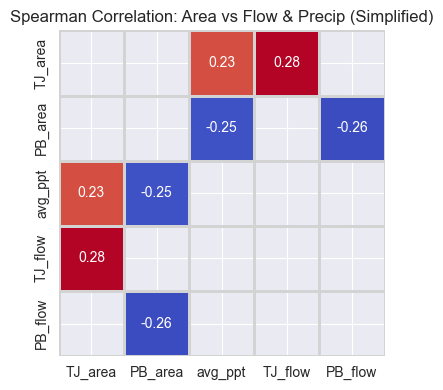

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1–3: Pivot and merge
df_wide = df.pivot_table(index='start_local', columns='Site', values='area_sqkm')
df_meta = df[['start_local', 'avg_ppt', 'TJNERR_flowrate_24h_avg_m3s', 'PB_flowrate_24h_avg_m3s']].drop_duplicates(subset='start_local')
df_combined = df_wide.merge(df_meta, on='start_local', how='left')

df_combined = df_combined.rename(columns={
    'TJ': 'TJ_area',
    'PB': 'PB_area',
    'TJNERR_flowrate_24h_avg_m3s': 'TJ_flow',
    'PB_flowrate_24h_avg_m3s': 'PB_flow'
})

# Subset the relevant columns
focus_vars = ['TJ_area', 'PB_area', 'avg_ppt', 'TJ_flow', 'PB_flow']
df_focus = df_combined[focus_vars].copy()

# Compute correlation matrix
corr = df_focus.corr(method='spearman')

# Build custom mask to hide everything except:
# TJ_area vs avg_ppt and TJ_flow
# PB_area vs avg_ppt and PB_flow
mask = np.ones_like(corr, dtype=bool)  # Start with all True (hide all)
keep_pairs = [
    ('TJ_area', 'avg_ppt'),
    ('TJ_area', 'TJ_flow'),
    ('PB_area', 'avg_ppt'),
    ('PB_area', 'PB_flow')
]

for row, col in keep_pairs:
    mask[corr.index.get_loc(row), corr.columns.get_loc(col)] = False
    mask[corr.index.get_loc(col), corr.columns.get_loc(row)] = False
    # Optionally keep diagonal
    if row == col:
        mask[corr.index.get_loc(row), corr.columns.get_loc(col)] = False

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, cbar=False,
            linewidths=1, linecolor='lightgrey', square=True)
plt.title('Spearman Correlation: Area vs Flow & Precip (Simplified)')
plt.tight_layout()
plt.show()



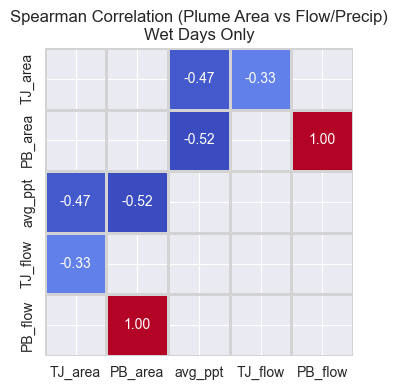

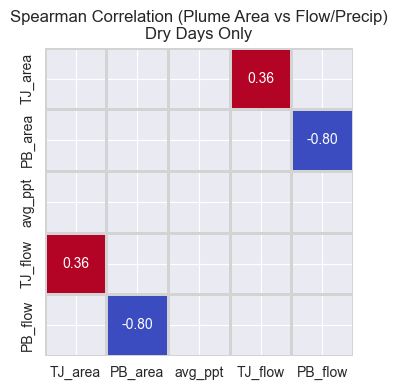

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute and plot simplified correlation matrix
def plot_site_correlation_matrix(df, label):
    # Step 1: Pivot area columns to wide format (TJ and PB)
    df_wide = df.pivot_table(index='start_local', columns='Site', values='area_sqkm')

    # Step 2: Merge with flow and precip data
    df_meta = df[['start_local', 'avg_ppt', 'TJNERR_flowrate_24h_avg_m3s', 'PB_flowrate_24h_avg_m3s']].drop_duplicates(subset='start_local')
    df_combined = df_wide.merge(df_meta, on='start_local', how='left')

    # Step 3: Rename columns for clarity
    df_combined = df_combined.rename(columns={
        'TJ': 'TJ_area',
        'PB': 'PB_area',
        'TJNERR_flowrate_24h_avg_m3s': 'TJ_flow',
        'PB_flowrate_24h_avg_m3s': 'PB_flow'
    })

    # Step 4: Select variables of interest
    focus_vars = ['TJ_area', 'PB_area', 'avg_ppt', 'TJ_flow', 'PB_flow']
    df_focus = df_combined[focus_vars].copy()

    # Step 5: Compute correlation matrix
    corr = df_focus.corr(method='spearman')

    # Step 6: Create a custom mask to keep only selected cells
    mask = np.ones_like(corr, dtype=bool)
    keep_pairs = [
        ('TJ_area', 'avg_ppt'),
        ('TJ_area', 'TJ_flow'),
        ('PB_area', 'avg_ppt'),
        ('PB_area', 'PB_flow')
    ]

    for row, col in keep_pairs:
        if row in corr.index and col in corr.columns:
            mask[corr.index.get_loc(row), corr.columns.get_loc(col)] = False
            mask[corr.index.get_loc(col), corr.columns.get_loc(row)] = False

    # Step 7: Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask,
                cbar=False, linewidths=1, linecolor='lightgrey', square=True)
    plt.title(f'Spearman Correlation (Plume Area vs Flow/Precip)\n{label} Days Only')
    plt.tight_layout()
    plt.show()

# ✅ Subset for wet days
df_wet = df[df['weather_class'] == 'wet'].copy()
plot_site_correlation_matrix(df_wet, label="Wet")

# ✅ Subset for dry days
df_dry = df[df['weather_class'] == 'dry'].copy()
plot_site_correlation_matrix(df_dry, label="Dry")


**regression modelling**

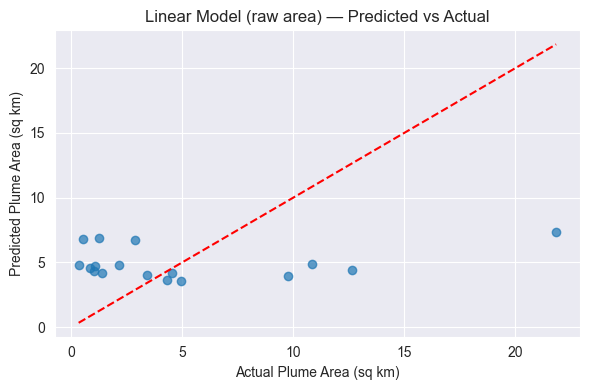


=== Linear Model (raw area) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.092
Method:                 Least Squares   F-statistic:                    0.3244
Date:                Mon, 28 Jul 2025   Prob (F-statistic):              0.728
Time:                        18:46:19   Log-Likelihood:                -53.003
No. Observations:                  17   AIC:                             112.0
Df Residuals:                      14   BIC:                             114.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/ereilly/RS/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)


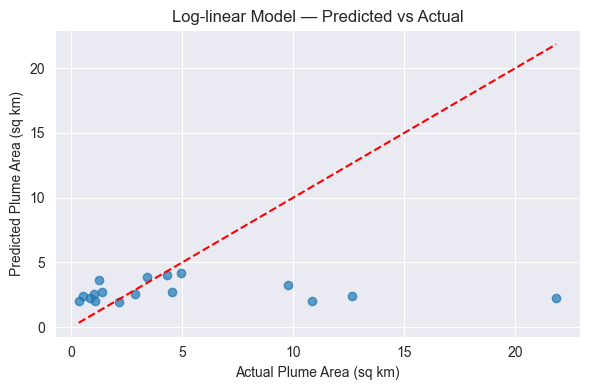


=== Log-linear Model ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.089
Method:                 Least Squares   F-statistic:                    0.3443
Date:                Mon, 28 Jul 2025   Prob (F-statistic):              0.715
Time:                        18:46:20   Log-Likelihood:                -26.006
No. Observations:                  17   AIC:                             58.01
Df Residuals:                      14   BIC:                             60.51
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

/Users/ereilly/RS/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)


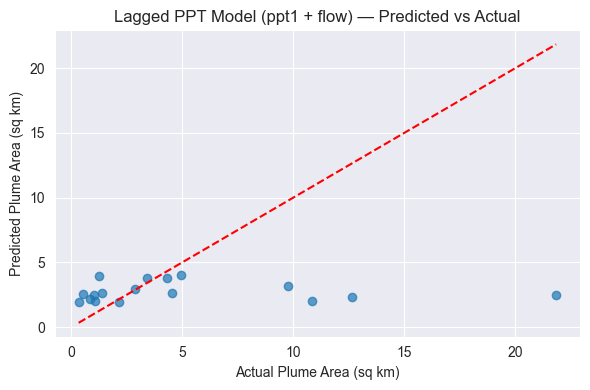


=== Lagged PPT Model (ppt1 + flow) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.091
Method:                 Least Squares   F-statistic:                    0.3330
Date:                Mon, 28 Jul 2025   Prob (F-statistic):              0.722
Time:                        18:46:20   Log-Likelihood:                -26.020
No. Observations:                  17   AIC:                             58.04
Df Residuals:                      14   BIC:                             60.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/Users/ereilly/RS/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)
/var/folders/t1/fsg48t9j38g7vrkbkp0603fr0000gq/T/ipykernel_88910/3091014988.py:96: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


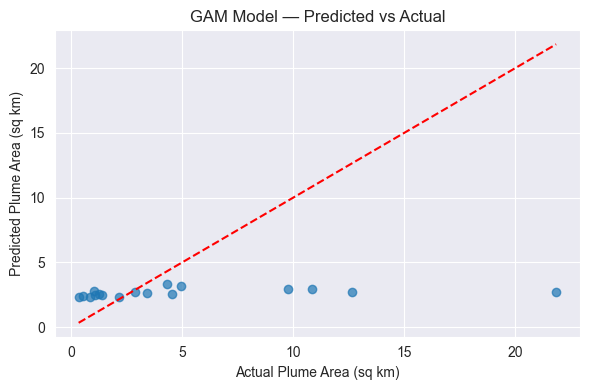

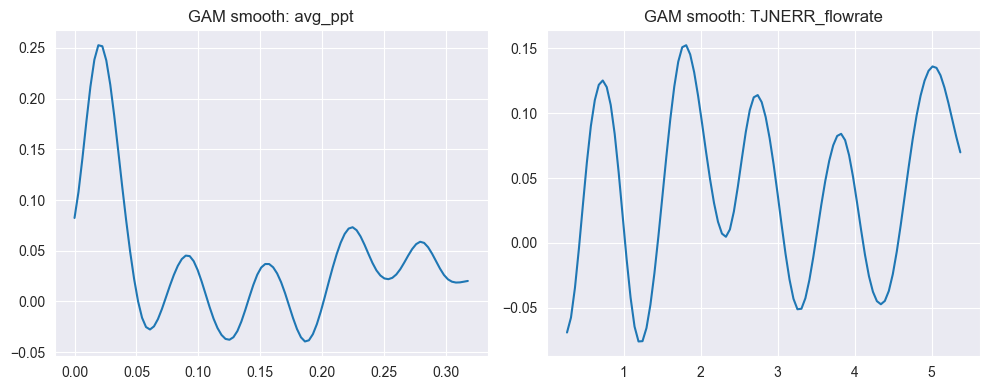


Summary Comparison (Linear Models Only):
Linear Model (raw area): R²=0.04, Adj R²=-0.09, AIC=112.0
Log-linear Model: R²=0.05, Adj R²=-0.09, AIC=58.0
Lagged PPT Model (ppt1 + flow): R²=0.05, Adj R²=-0.09, AIC=58.0


In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# === 0. Setup ===
def evaluate_model(df, predictors, response, label, log_transform=False):
    df_model = df[predictors + [response]].dropna().copy()

    if log_transform:
        df_model = df_model[df_model[response] > 0].copy()
        df_model['y'] = np.log(df_model[response])
    else:
        df_model['y'] = df_model[response]

    if len(df_model) < 5:
        print(f"{label}: Not enough data")
        return None

    X = sm.add_constant(df_model[predictors])
    y = df_model['y']
    model = sm.OLS(y, X).fit()

    # Get predictions (back-transform if needed)
    df_model['pred'] = model.predict(X)
    if log_transform:
        df_model['actual'] = np.exp(df_model['y'])
        df_model['pred'] = np.exp(df_model['pred'])
    else:
        df_model['actual'] = df_model['y']

    # Plot predicted vs actual
    plt.figure(figsize=(6, 4))
    plt.scatter(df_model['actual'], df_model['pred'], alpha=0.7)
    min_val = min(df_model['actual'].min(), df_model['pred'].min())
    max_val = max(df_model['actual'].max(), df_model['pred'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Actual Plume Area (sq km)')
    plt.ylabel('Predicted Plume Area (sq km)')
    plt.title(f'{label} — Predicted vs Actual')
    plt.tight_layout()
    plt.show()

    print(f"\n=== {label} ===")
    print(model.summary())

    return {
        "label": label,
        "model": model,
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
        "aic": model.aic
    }

# === 1. Load TJ data (all days) ===
df_tj = df[df['Site'] == 'TJ'].copy()

# === 2. Linear Model on raw area ===
m1 = evaluate_model(
    df_tj,
    predictors=['avg_ppt', 'TJNERR_flowrate_24h_avg_m3s'],
    response='area_sqkm',
    label="Linear Model (raw area)",
    log_transform=False
)

# === 3. Log-linear Model ===
m2 = evaluate_model(
    df_tj,
    predictors=['avg_ppt', 'TJNERR_flowrate_24h_avg_m3s'],
    response='area_sqkm',
    label="Log-linear Model",
    log_transform=True
)

# === 4. Lagged PPT Model ===
m3 = evaluate_model(
    df_tj,
    predictors=['ppt1', 'TJNERR_flowrate_24h_avg_m3s'],
    response='area_sqkm',
    label="Lagged PPT Model (ppt1 + flow)",
    log_transform=True
)

# === 5. GAM Model ===
df_gam = df_tj[['area_sqkm', 'avg_ppt', 'TJNERR_flowrate_24h_avg_m3s']].dropna()
df_gam = df_gam[df_gam['area_sqkm'] > 0].copy()

X = df_gam[['avg_ppt', 'TJNERR_flowrate_24h_avg_m3s']].values
y = np.log(df_gam['area_sqkm'].values)

gam = LinearGAM(s(0) + s(1)).fit(X, y)
print("\n=== GAM Model ===")
print(gam.summary())

# === 6. GAM: Visual Fit ===
df_gam['pred_log'] = gam.predict(X)
df_gam['pred'] = np.exp(df_gam['pred_log'])

plt.figure(figsize=(6, 4))
plt.scatter(df_gam['area_sqkm'], df_gam['pred'], alpha=0.7)
min_val = min(df_gam['area_sqkm'].min(), df_gam['pred'].min())
max_val = max(df_gam['area_sqkm'].max(), df_gam['pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Actual Plume Area (sq km)')
plt.ylabel('Predicted Plume Area (sq km)')
plt.title('GAM Model — Predicted vs Actual')
plt.tight_layout()
plt.show()

# === 7. GAM Smooths ===
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
titles = ['avg_ppt', 'TJNERR_flowrate']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set_title(f"GAM smooth: {titles[i]}")
plt.tight_layout()
plt.show()

# === 8. Compare Linear Models ===
models = [m for m in [m1, m2, m3] if m is not None]
print("\nSummary Comparison (Linear Models Only):")
for m in models:
    print(f"{m['label']}: R²={m['r2']:.2f}, Adj R²={m['adj_r2']:.2f}, AIC={m['aic']:.1f}")



<Axes: xlabel='avg_ppt', ylabel='area_sqkm'>

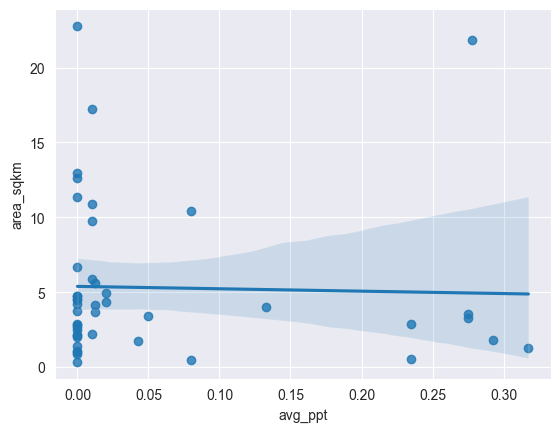

In [88]:
sns.regplot(data=df, x='avg_ppt', y='area_sqkm')


**calculate precipitation lag effect**

In [32]:
import pandas as pd
import numpy as np

# 1. Load & prep data
main_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/Master.xlsx")
precip_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx")

main_df['date'] = pd.to_datetime(main_df['start_utc']).dt.date
precip_df['date'] = pd.to_datetime(precip_df['Date']).dt.date

# 2. Reshape precip and merge
ppt_long = precip_df.melt(
    id_vars='date',
    value_vars=['ppt_tj', 'ppt_pb'],
    var_name='ppt_var', value_name='ppt_in'
)
ppt_long['Site'] = ppt_long['ppt_var'].map({'ppt_tj': 'TJ', 'ppt_pb': 'PB'})

df = main_df.merge(ppt_long[['date', 'Site', 'ppt_in']], on=['date','Site'], how='inner')

# 3. Loop per site: compute lag correlations and windowed correlations
for site in df['Site'].unique():
    sub = df[df['Site'] == site].sort_values('date').set_index('date')
    x = sub['ppt_in'] - sub['ppt_in'].mean()
    y = sub['area_sqkm'] - sub['area_sqkm'].mean()

    # Single-day lag correlations
    lags = np.arange(0, 15)
    corrs = [x.shift(lag).corr(y) for lag in lags]
    lag_df = pd.DataFrame({'lag_days': lags, 'r': corrs})
    lag_df['abs_r'] = lag_df['r'].abs()

    print(f"\n=== Site {site}: Single-day lag correlations ===")
    print(lag_df.sort_values('abs_r', ascending=False).reset_index(drop=True))

    # Multi-day windowed correlations
    results = []
    for window in [1, 3, 5, 7, 10]:
        roll = sub['ppt_in'].rolling(window, min_periods=1).sum()
        for lag in lags:
            r = roll.shift(lag).corr(y)
            results.append((window, lag, r))
    win_df = pd.DataFrame(results, columns=['window_days','lag_days','r'])
    win_df['abs_r'] = win_df['r'].abs()

    print(f"\n=== Site {site}: Top 10 windowed correlations ===")
    print(win_df.sort_values('abs_r', ascending=False).head(10).reset_index(drop=True))




=== Site TJ: Single-day lag correlations ===
    lag_days         r     abs_r
0         12  0.797755  0.797755
1         10 -0.322852  0.322852
2          8 -0.292854  0.292854
3         11  0.259007  0.259007
4          7 -0.254874  0.254874
5          6 -0.240204  0.240204
6          0  0.216600  0.216600
7          9 -0.214081  0.214081
8          2 -0.188307  0.188307
9          1 -0.074895  0.074895
10        13 -0.058787  0.058787
11         4 -0.047613  0.047613
12         5 -0.046248  0.046248
13         3 -0.033525  0.033525
14        14       NaN       NaN

=== Site TJ: Top 10 windowed correlations ===
   window_days  lag_days         r     abs_r
0           10        11  0.896433  0.896433
1            3        11  0.896433  0.896433
2            5        11  0.896433  0.896433
3            7        11  0.896433  0.896433
4            1        12  0.797755  0.797755
5            5        12  0.712631  0.712631
6           10        12  0.712631  0.712631
7            7     

/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ereilly/RS/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


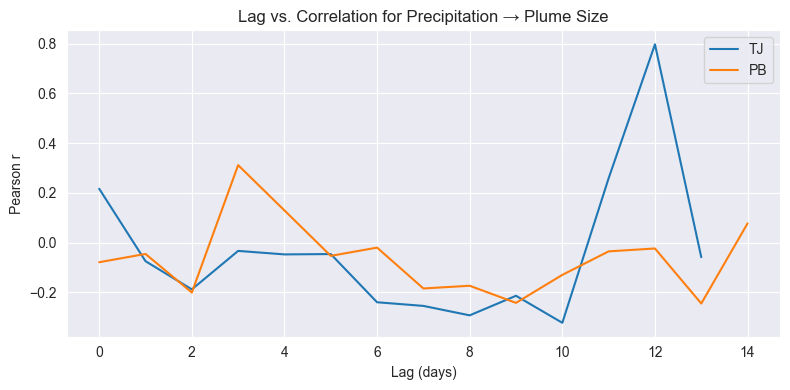

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load & prepare data (adjust paths as needed)
main_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/Master.xlsx")
precip_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx")

main_df['date'] = pd.to_datetime(main_df['start_utc']).dt.date
precip_df['date'] = pd.to_datetime(precip_df['Date']).dt.date

# 2. Reshape precipitation and merge
ppt_long = precip_df.melt(
    id_vars='date',
    value_vars=['ppt_tj', 'ppt_pb'],
    var_name='ppt_var', value_name='ppt_in'
)
ppt_long['Site'] = ppt_long['ppt_var'].map({'ppt_tj': 'TJ', 'ppt_pb': 'PB'})
df = main_df.merge(ppt_long[['date', 'Site', 'ppt_in']], on=['date', 'Site'], how='inner')

# 3. Compute correlation for lags 0–14 for each site
lags = np.arange(0, 15)
corrs = {}

for site in df['Site'].unique():
    sub = df[df['Site'] == site].sort_values('date').set_index('date')
    x = sub['ppt_in'] - sub['ppt_in'].mean()
    y = sub['area_sqkm'] - sub['area_sqkm'].mean()
    corrs[site] = [x.shift(lag).corr(y) for lag in lags]

# 4. Plot lag vs correlation
plt.figure(figsize=(8, 4))
for site, values in corrs.items():
    plt.plot(lags, values, label=site)
plt.xlabel("Lag (days)")
plt.ylabel("Pearson r")
plt.title("Lag vs. Correlation for Precipitation → Plume Size")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
import pandas as pd
import numpy as np

# 1. Load & prepare data (adjust paths as needed)
main_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/Master.xlsx")
precip_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx")


main_df['date']   = pd.to_datetime(main_df['start_utc']).dt.date
precip_df['date'] = pd.to_datetime(precip_df['Date']).dt.date

# 2. Reshape precip to long form and merge
ppt_long = (
    precip_df
    .melt(id_vars='date', value_vars=['ppt_tj','ppt_pb'],
          var_name='ppt_var', value_name='ppt_in')
)
ppt_long['Site'] = ppt_long['ppt_var'].map({'ppt_tj':'TJ','ppt_pb':'PB'})

df = main_df.merge(
    ppt_long[['date','Site','ppt_in']],
    on=['date','Site'],
    how='inner'
)

# 3. Compute correlation for window=1…9 and lag=0…9, plus days_prior
results = []
for site in df['Site'].unique():
    sub = (df[df['Site']==site]
           .sort_values('date')
           .set_index('date'))
    y = sub['area_sqkm']
    for window in range(1,10):      # windows 1–9 days
        roll = sub['ppt_in'].rolling(window, min_periods=1).sum()
        for lag in range(0,10):     # lags 0–9 days
            r = roll.shift(lag).corr(y)
            # days_prior = list of days BEFORE the plume: [lag, lag+1, …, lag+window-1]
            days_prior = tuple(range(lag, lag + window))
            results.append({
                'Site':       site,
                'window_days':window,
                'lag_days':   lag,
                'days_prior': days_prior,
                'r':          r,
                'abs_r':      abs(r) if pd.notna(r) else np.nan
            })

# 4. Build DataFrame, save & inspect
all_df = pd.DataFrame(results)

# Save EVERYTHING to CSV
all_df.to_csv("/Volumes/External/TJ_SAR/analysis/all_window_lag_per_site_with_days.csv", index=False)

# Optionally, just print the head to check
print(all_df[['Site','window_days','lag_days','days_prior','r']].head(20))

print("Saved all_window_lag_per_site.csv")

   Site  window_days  lag_days days_prior         r
0    TJ            1         0       (0,)  0.216600
1    TJ            1         1       (1,) -0.074895
2    TJ            1         2       (2,) -0.188307
3    TJ            1         3       (3,) -0.033525
4    TJ            1         4       (4,) -0.047613
5    TJ            1         5       (5,) -0.046248
6    TJ            1         6       (6,) -0.240204
7    TJ            1         7       (7,) -0.254874
8    TJ            1         8       (8,) -0.292854
9    TJ            1         9       (9,) -0.214081
10   TJ            2         0     (0, 1)  0.107972
11   TJ            2         1     (1, 2) -0.179520
12   TJ            2         2     (2, 3) -0.152687
13   TJ            2         3     (3, 4) -0.069932
14   TJ            2         4     (4, 5) -0.063342
15   TJ            2         5     (5, 6) -0.194209
16   TJ            2         6     (6, 7) -0.364371
17   TJ            2         7     (7, 8) -0.401927
18   TJ     

**add wet/dry condition to spreadsheet**

In [60]:
import pandas as pd

# 1. Load data (adjust paths as needed)
main_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/Master.xlsx")
precip_df = pd.read_excel("/Volumes/External/TJ_SAR/analysis/_data/PRISM_ppt_tmean_early_4km_20200101_20250701_32.5433_-117.1165.xlsx")

# 2. Prepare date columns
main_df['date']   = pd.to_datetime(main_df['start_utc']).dt.date
precip_df['date'] = pd.to_datetime(precip_df['Date']).dt.date

# 3. Reshape precipitation to long form and merge
ppt_long = precip_df.melt(
    id_vars='date',
    value_vars=['ppt_tj', 'ppt_pb'],
    var_name='ppt_var',
    value_name='ppt_in'
)
ppt_long['Site'] = ppt_long['ppt_var'].map({'ppt_tj':'TJ','ppt_pb':'PB'})

df = main_df.merge(
    ppt_long[['date','Site','ppt_in']],
    on=['date','Site'],
    how='left'
).sort_values(['Site','date'])

# 4. Create lagged precip columns for the previous 3 days (t-1, t-2, t-3)
for i in (1, 2, 3):
    df[f'ppt_m{i}'] = df.groupby('Site')['ppt_in'].shift(i)

# 5. Classify each row:
#    - 'rain' if ANY of the last 3 days > threshold
#    - 'wet'  if none exceed threshold but at least one > 0
#    - 'dry'  if all three days == 0 or NaN
threshold = 0.00393701  # inches

def classify(v1, v2, v3, thresh=threshold):
    vals = [v for v in (v1, v2, v3) if pd.notna(v)]
    if any(v > thresh for v in vals):
        return 'rain'
    elif any(v > 0 for v in vals):
        return 'wet'
    else:
        return 'dry'

df['weather_class'] = df.apply(lambda row: classify(row.ppt_m1, row.ppt_m2, row.ppt_m3), axis=1)

# 6. Save and preview
df.to_csv("/Volumes/External/TJ_SAR/analysis/precip_condition.csv", index=False)
print(df[['date','Site','ppt_m1','ppt_m2','ppt_m3','weather_class']].head(10))


          date Site  ppt_m1  ppt_m2  ppt_m3 weather_class
44  2022-12-03   PB     NaN     NaN     NaN           dry
41  2022-12-15   PB    0.00     NaN     NaN           dry
43  2022-12-15   PB    0.00    0.00     NaN           dry
38  2023-10-23   PB    0.00    0.00    0.00           dry
36  2023-12-22   PB    0.00    0.00    0.00           dry
37  2023-12-22   PB    0.48    0.00    0.00          rain
35  2024-01-03   PB    0.48    0.48    0.00          rain
34  2024-03-03   PB    0.00    0.48    0.48          rain
32  2024-03-15   PB    0.18    0.00    0.48          rain
27  2024-04-08   PB    0.04    0.18    0.00          rain


In [2]:
import rasterio
import numpy as np

# Open your source raster
with rasterio.open('/Volumes/External/TJ_SAR/06_shapefiles/density.tif') as src:
    profile = src.profile.copy()
    data = src.read(1).astype('float32')   # read as float

# Apply linear scaling
scaled = (data / 38.0) * 100.0

# (Optional) if you have nodata in the source, mask it:
# mask = data == src.nodata
# scaled[mask] = src.nodata

# Update profile for float output
profile.update(
    dtype=rasterio.float32,
    nodata=None  # or keep src.nodata if you masked above
)

# Write out the probability raster
with rasterio.open('/Volumes/External/TJ_SAR/06_shapefiles/density_probability.tif', 'w', **profile) as dst:
    dst.write(scaled, 1)
